In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import snscrape.modules.twitter as sntwitter
import itertools, re, nltk
import time, numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns, networkx as nx
from matplotlib.colors import ListedColormap
from textblob import TextBlob
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from unidecode import unidecode
from nltk.tag import CRFTagger
from html import unescape
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tqdm import tqdm
import spacy
import pyLDAvis
from spacy.lang.id import Indonesian
import twint
import nest_asyncio
import urllib.request as rq
import plotly
import plotly.express as px
from bs4 import BeautifulSoup
from imp import reload
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models
stemmer = StemmerFactory().create_stemmer()

## Impor data dan melihat info data.

In [4]:
data_raw = pd.read_csv("Data Raw Piala Dunia 2022 Qatar.csv")
data_raw.drop(columns = 'Unnamed: 0', inplace = True)
data_raw.head()

,id,tweet,username,photos,video,name,date,nlikes,nreplies,nretweets
0,1604989890772418560,Piala Dunia FIFA 2022 di Qatar paling banyak d...,medan_sib,['https://pbs.twimg.com/media/FkYRytMUAAETvvt....,1,Medan SIB,2022-12-20 06:59:43,1,0,0
1,1604989580071116800,Meski pernah merasakan gelar Piala Dunia pada ...,detikcom,[],0,detikcom,2022-12-20 06:58:29,14,0,1
2,1604989149429510144,Piala Dunia 2026 Memakai Cara Berbeda dari Pia...,Jankisnihbos,[],0,Jankisnihbos,2022-12-20 06:56:47,1,0,1
3,1604988946043514880,Piala Dunia 2026 Memakai Cara Berbeda dari Pia...,Jankisnihbos,[],0,Jankisnihbos,2022-12-20 06:55:58,0,0,0
4,1604988858906447872,#news #berita #fakta #indonesia #viral #berita...,rikagami1,[],0,rika gami,2022-12-20 06:55:37,0,0,0


In [5]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11003 entries, 0 to 11002
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         11003 non-null  int64 
 1   tweet      11003 non-null  object
 2   username   11003 non-null  object
 3   photos     11003 non-null  object
 4   video      11003 non-null  int64 
 5   name       11003 non-null  object
 6   date       11003 non-null  object
 7   nlikes     11003 non-null  int64 
 8   nreplies   11003 non-null  int64 
 9   nretweets  11003 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 859.7+ KB
None


In [6]:
# Memcari dan menghilangkan data yang terduplikasi.
print("Jumlah data yang terduplikasi berdasarkan tweet dan username:")
print(data_raw.duplicated(subset = ['tweet','username']).sum())
data_raw.drop_duplicates(subset = ['tweet','username'], inplace = True)
print("Duplicated data by tweet and username after removal :")
print(data_raw.duplicated(subset = ['tweet','username']).sum())

Jumlah data yang terduplikasi berdasarkan tweet dan username:
62
Duplicated data by tweet and username after removal :
0


In [7]:
# mengubah tipe data menjadi datetime.
data_raw['date'] = pd.to_datetime(data_raw['date'],format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [8]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10941 entries, 0 to 11002
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         10941 non-null  int64         
 1   tweet      10941 non-null  object        
 2   username   10941 non-null  object        
 3   photos     10941 non-null  object        
 4   video      10941 non-null  int64         
 5   name       10941 non-null  object        
 6   date       10941 non-null  datetime64[ns]
 7   nlikes     10941 non-null  int64         
 8   nreplies   10941 non-null  int64         
 9   nretweets  10941 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 940.2+ KB
None


In [9]:
# Membuat filter tweet dengan regex.
emailPattern = re.compile(r'[\w._%+-]+@[\w\.-]+\.[a-zA-Z]{2,4}')
urlPattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
phonePattern = re.compile(r'(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})')
numbers_pattern = re.compile(r'[0-9]')
hastag_pattern = re.compile(r"#(\w+)")
hastag_pattern_split = re.compile(r'[A-Z][^A-Z]*')
filter_laugh = re.compile(r"\b(?:a*(?:ha)+h?|(?:w+k+)+w+k|(?:w+k+)+w+k+k|(?:a+w+o+k+)+w+o+k|(?:l+o)+l)\b")

In [10]:
# Stop words & Slangs.

Sastrawi_StopWords_id = StopWordRemoverFactory().get_stop_words()
Sastrawi_StopWords_id = set(Sastrawi_StopWords_id)
Sastrawi_StopWords_id.add('rt')
print("Count stop words :")
print(len(Sastrawi_StopWords_id))

# Menambahkan stop words baru dari internet.
html = rq.urlopen('https://raw.githubusercontent.com/masdevid/ID-Stopwords/master/id.stopwords.02.01.2016.txt')
raw = BeautifulSoup(html).text
new_stopwords = raw.split('\n')
for kata in new_stopwords:
    Sastrawi_StopWords_id.add(kata)
print("Count new stop words :")
print(len(Sastrawi_StopWords_id))

# kata-kata slang.
SlangS = {'gan':'juragan', 'yg':'yang', 'dgn':'dengan', 'u': 'you', 'ndak':'tidak', 'sesok':'besok', 'gw' : 'saya', 'lo' : 'kamu', 'bokap' : 'ayah', 'nyokap': 'ibu', 'sokin' : 'sini', 'mager' : 'males',
         'julid' : 'iri', 'ngga' : 'tidak', 'jd' : 'jadi', 'sabeb' : 'bebas', 'sabi' : 'bisa', 'cabs' : 'cabut', 'woles' : 'santai', 'rokum' : 'rumah', 'cabs' : 'pergi', 'saik' : 'asik', 'i' : 'saya', 'I' : 'saya'} 

add_slangwords = ["blm","udh","lg","ud","spt","min","ntn","bravo","krn","sm","team","suek","mantul","anjay","anjas","anjir","nongki"]
baku_words = ["belum","sudah","lagi","sudah","seperti","admin","tonton","keren","karena","sama","tim","sialan","mantap betul","keren","keren","sialan","nongkrong bareng"]
zipped_ = list(zip(add_slangwords,baku_words))
print("Count of new slangs :")
print(len(zipped_))
print("Original slangs :")
print(len(SlangS))

# menambahkan beberapa kata slang baru.
for val in zipped_:
    SlangS[val[0]] = val[1]
print("New slangs :")
print(len(SlangS))

Count stop words :
124
Count new stop words :
775
Count of new slangs :
17
Original slangs :
23
New slangs :
40


In [11]:
# Menghilangkan huruf yang berulang di akhir kata. misal : Sayaaa -> saya.
def remove_doublewords(word):
    try :
        int_converted = int(word)
        return word
    except :
        if word[-2] == word[-1] :
            for i in range(2, len(word)+1):
                if word[-i] != word[-i+1]:
                    word = word[:-i+2]
                    break            
            return word
        else:
            return word

# Menghilangkan hastag.
def remove_hastag(text):
    tags = re.findall(hastag_pattern,text)
    for tag in tags:
        proper_words = ' '.join(re.findall(hastag_pattern_split,tag))
        text = text.replace("#" + tag, proper_words)
    return text

# Melakukan post tagging.
def nlpfilter(tokens):
    ct = CRFTagger()
    ct.set_model_file('all_indo_man_tag_corpus_model.crf.tagger')
    filters = set(['NN', 'NNP', 'NNS', 'NNPS', 'JJ'])
    hasil_ = ct.tag_sents([tokens])
    return ' '.join([k[0] for k in hasil_[0] if k[1] in filters])

# Menghitung nilai coherence.
def compute_coherence_values(id2word, corpus, texts, limit=1, start=2, step=1):
    coherence_values = []
    for num_topics in range(start, limit, step):
        LDAmodel_ = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
        cm = CoherenceModel(model=LDAmodel_, texts=texts, corpus=corpus, coherence='c_v')
        with np.errstate(invalid='ignore'):
            coherence_values.append(cm.get_coherence())
    return coherence_values

# fungsi untuk membersihkan tweet.
def cleanText(txt):
    docx = re.sub(urlPattern,' ', txt) # remove links
    docx = re.sub(emailPattern, ' ', docx) # remove email
    docx = remove_hastag(docx) # remove hastag
    docx = unidecode(unescape(docx.lower().strip())) # remove emoticon and etc
    docx = re.sub(r'[^\w]', ' ', docx) # remove symbol, keep "_"
    docx = re.sub(filter_laugh,' ',docx) # rmeove laughing words
    Tokens = TextBlob(docx).words # Tokenisasi
    Tokens = [remove_doublewords(t) if len(t) > 2 else t for t in Tokens]# remove double words
    Tokens = [SlangS[t] if (SlangS.get(t) != None) else t for t in Tokens] # convert slangs
    Tokens = [t for t in Tokens if str(t) not in Sastrawi_StopWords_id and len(t)>2]# Stopwords filtering
    docx= nlpfilter(Tokens)
    docx = stemmer.stem(docx)
    return docx # Silahkan latihan tambahkan penanganan Slang/Singkatan

In [13]:
# melalukan tes pada suatu string.
tweet_test = "Potret kepedulian personel Polwan RI #MelindungiMelayaniWarga saat menggelar trauma healing untuk anak-anak pengungsian di Cianjur, Jawa Barat.\
Sinergitas Untuk Negeri #Poldajabar.25  https://t.co/fx7C6ShJ8x wkwkwkwk gw juga turut perihatin cabs dulu ya, messiii, mengibaratkannya mengerjakan sejauh pertanyakan dong \U0001F62A 2022"
new_tweet_test = cleanText(tweet_test)
print("Before :")
print(tweet_test)
print(" ")
print("After :")
print(new_tweet_test)

Before :
Potret kepedulian personel Polwan RI #MelindungiMelayaniWarga saat menggelar trauma healing untuk anak-anak pengungsian di Cianjur, Jawa Barat.Sinergitas Untuk Negeri #Poldajabar.25  https://t.co/fx7C6ShJ8x wkwkwkwk gw juga turut perihatin cabs dulu ya, messiii, mengibaratkannya mengerjakan sejauh pertanyakan dong 😪 2022
 
After :
potret peduli personel polwan warga gelar trauma healing anak anak ungsi cianjur barat sinergitas negeri poldajabar perihatin messi


In [14]:
# Membuat variabel baru yang berisikan tweet yang sudah dibersihkan.
data_raw['clean tweets'] = data_raw.loc[:,'tweet'].apply(cleanText)

In [15]:
# Membuat copy
data_clean = data_raw.copy()
print(data_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10941 entries, 0 to 11002
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            10941 non-null  int64         
 1   tweet         10941 non-null  object        
 2   username      10941 non-null  object        
 3   photos        10941 non-null  object        
 4   video         10941 non-null  int64         
 5   name          10941 non-null  object        
 6   date          10941 non-null  datetime64[ns]
 7   nlikes        10941 non-null  int64         
 8   nreplies      10941 non-null  int64         
 9   nretweets     10941 non-null  int64         
 10  clean tweets  10941 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 1.0+ MB
None


## Exploratory Data Analysis.

In [19]:
# Melihat nama akun dan tweet yang menjadi top 10 berdasarkan retweets dan likes.
grouped_1 = data_clean.groupby('tweet')[['nretweets','nlikes']].sum()
top_10_2 = grouped_1.nlargest(10,['nretweets','nlikes']).reset_index()
top_10_2
name = [data_clean[data_clean['tweet'] == i]['name'].values[0] for i in top_10_2['tweet']]
top_10_2['name'] = name
top_10_2

,tweet,nretweets,nlikes,name
0,Rekapan keseruan reaksi final piala dunia 2022...,3830,13741,Yono bakrie
1,"Untuk keempat kalinya secara beruntun, EA Spor...",1350,8404,Extra Time Indonesia
2,"• 64 Pertandingan • 172 Goal • 3,404,252 keha...",1049,5746,Fakta Bola ⚽
3,Yuk tebak skor Argentina vs Prancis Syaratnya...,1024,781,Info Suporter Indonesia
4,Usai sudah 64 pertandingan di Piala Dunia 2022...,629,3141,Extra Time Indonesia
5,2022: ARGENTINA JUARA PIALA DUNIA. ⭐️⭐️⭐️ (En...,622,3115,Extra Time Indonesia
6,"""Selamat anak-anakku Argentina, telah berhasil...",510,1398,Komisi Wasit
7,"PEMAIN TERBAIK PIALA DUNIA 2022, 🐐🇦🇷 https://...",354,2308,Extra Time Indonesia
8,"Untuk sampai kesini, Messi telah melalui keped...",343,1425,The Reds Indonesia
9,RASMI PEMENANG ANUGERAH PIALA DUNIA FIFA QATA...,340,741,Irfan_newboys🇲🇾🇵🇸🏳️🏴


In [20]:
# membaut variabel baru berdasarkan status ada atau tidaknya video pada tweet.
video_ = data_clean[data_clean["video"] == 1]
wvideo_ = data_clean[data_clean["video"] == 0]

# akan dilihat apakah terdapat perbedaan jumlah retweet dan like berdasarkan status ada atau tidaknya video pada tweet.
video_likes = video_["nlikes"].sum()
video_retweet = video_["nretweets"].sum()

wvideo_likes = wvideo_["nlikes"].sum()
wvideo_retweet = wvideo_["nretweets"].sum()

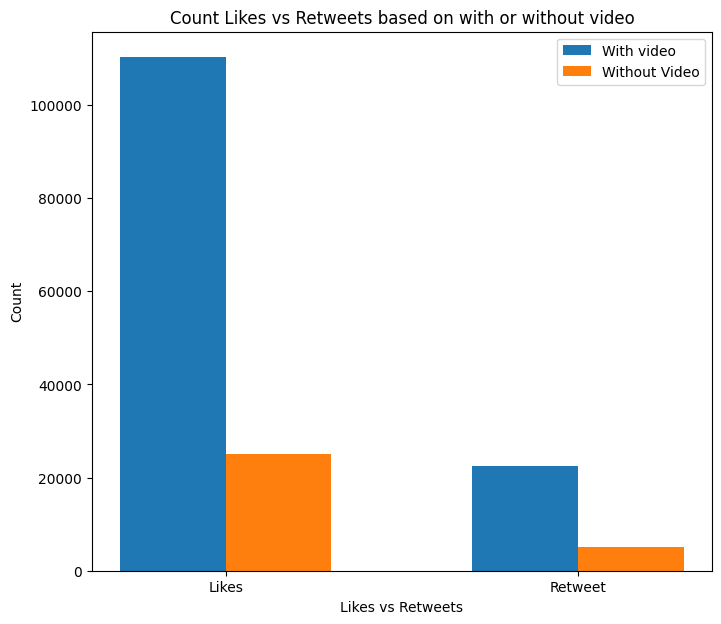

In [21]:
# Jumlah bar.
N = 2

# Mendefinisikan tinggi dari bar 1 dan 2
bar_1 = (video_likes,video_retweet)
bar_2 = (wvideo_likes,wvideo_retweet)

ind = np.arange(N)
plt.figure(figsize=(8,7))
width = 0.3       

# Plotting
plt.bar(ind, bar_1, width, label='With video')
plt.bar(ind + width, bar_2, width, label='Without Video')
plt.xlabel('Likes vs Retweets')
plt.ylabel('Count')
plt.title('Count Likes vs Retweets based on with or without video')
plt.xticks(ind + width / 2, ('Likes', 'Retweet'))
plt.legend(loc='best')
plt.show()

In [22]:
# Akan dilihat top 5 data apabila di tweetnya terdapat video.
grouped_2 = video_.groupby('tweet')[['nretweets','nlikes']].sum()
top_5_2 = grouped_2.nlargest(5,['nretweets','nlikes']).reset_index()
name_videos = [video_[video_['tweet'] == i]['name'].values[0] for i in top_5_2['tweet']]
top_5_2['name'] = name_videos

# Akan dilihat top 5 data apabila di tweetnya tidak terdapat video.
grouped_3 = wvideo_.groupby('tweet')[['nretweets','nlikes']].sum()
top_5_3 = grouped_3.nlargest(5,['nretweets','nlikes']).reset_index()
name_wvideos = [wvideo_[wvideo_['tweet'] == i]['name'].values[0] for i in top_5_3['tweet']]
top_5_3['name'] = name_wvideos

In [23]:
# data dengan video.
top_5_2

,tweet,nretweets,nlikes,name
0,Rekapan keseruan reaksi final piala dunia 2022...,3830,13741,Yono bakrie
1,"Untuk keempat kalinya secara beruntun, EA Spor...",1350,8404,Extra Time Indonesia
2,"• 64 Pertandingan • 172 Goal • 3,404,252 keha...",1049,5746,Fakta Bola ⚽
3,Yuk tebak skor Argentina vs Prancis Syaratnya...,1024,781,Info Suporter Indonesia
4,Usai sudah 64 pertandingan di Piala Dunia 2022...,629,3141,Extra Time Indonesia


In [24]:
# data tanpa video.
top_5_3

,tweet,nretweets,nlikes,name
0,RASMI PEMENANG ANUGERAH PIALA DUNIA FIFA QATA...,340,741,Irfan_newboys🇲🇾🇵🇸🏳️🏴
1,Piala Dunia 2022 Qatar akan jadi salah satu Pi...,306,682,Fakta Bola ⚽
2,BECAUSE IM SO HAPPYYYYYYY ARGENTINA FINALLY WO...,187,41,world cup champs!🇦🇷
3,"Save termahal di Piala Dunia 2022, menit 120, ...",180,1220,Extra Time Indonesia
4,"@nyktofilos @westenthu ""piala dunia ni bos sen...",104,3290,Nothing


In [25]:
# membaut variabel baru berdasarkan status ada atau tidaknya gambar pada tweet.
wphotos_ = data_clean[data_clean["photos"] == '[]']
photos_ = data_clean[data_clean["photos"] != '[]']

# akan dilihat apakah terdapat perbedaan jumlah retweet dan like berdasarkan status ada atau tidaknya gambar pada tweet.
photos_likes = photos_["nlikes"].sum()
photos_retweet = photos_["nretweets"].sum()
wphotos_likes = wphotos_["nlikes"].sum()
wphotos_retweet = wphotos_["nretweets"].sum()

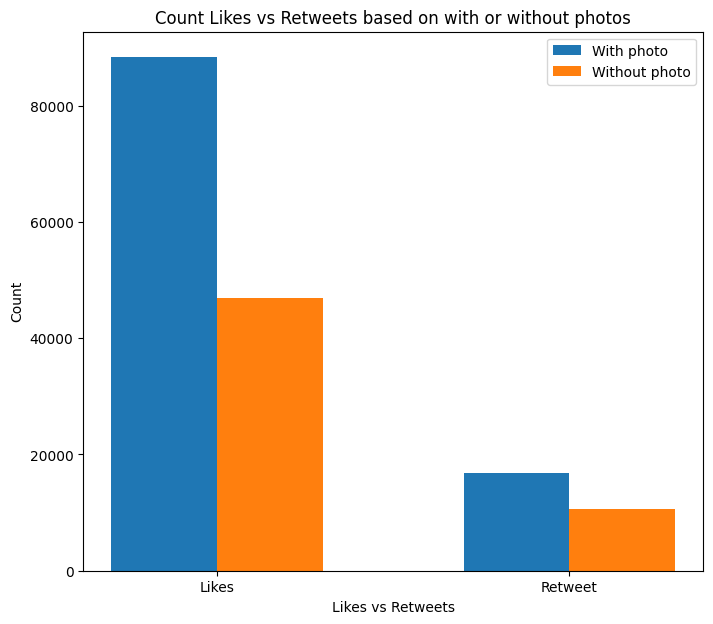

In [27]:
# Jumlah bar.
N = 2

# Mendefinisikan tinggi dari bar 1 dan 2
bar_1 = (photos_likes,photos_retweet)
bar_2 = (wphotos_likes,wphotos_retweet)

ind = np.arange(N)
plt.figure(figsize=(8,7))
width = 0.3       

# Plotting
plt.bar(ind, bar_1, width, label='With photo')
plt.bar(ind + width, bar_2, width, label='Without photo')
plt.xlabel('Likes vs Retweets')
plt.ylabel('Count')
plt.title('Count Likes vs Retweets based on with or without photos')
plt.xticks(ind + width / 2, ('Likes', 'Retweet'))
plt.legend(loc='best')
plt.show()

In [29]:
# Akan dilihat top 5 data apabila di tweetnya terdapat gambar.
grouped_4 = photos_.groupby('tweet')[['nretweets','nlikes']].sum()
top_5_4 = grouped_4.nlargest(5,['nretweets','nlikes']).reset_index()
name_photos = [photos_[photos_['tweet'] == i]['name'].values[0] for i in top_5_4['tweet']]
top_5_4['name'] = name_photos

# Akan dilihat top 5 data apabila di tweetnya tidak terdapat gambar.
grouped_5 = wphotos_.groupby('tweet')[['nretweets','nlikes']].sum()
top_5_5 = grouped_5.nlargest(5,['nretweets','nlikes']).reset_index()
name_wphotos = [wphotos_[wphotos_['tweet'] == i]['name'].values[0] for i in top_5_5['tweet']]
top_5_5['name'] = name_wphotos

In [30]:
# data dengan gambar.
top_5_4

,tweet,nretweets,nlikes,name
0,"Untuk keempat kalinya secara beruntun, EA Spor...",1350,8404,Extra Time Indonesia
1,"• 64 Pertandingan • 172 Goal • 3,404,252 keha...",1049,5746,Fakta Bola ⚽
2,Yuk tebak skor Argentina vs Prancis Syaratnya...,1024,781,Info Suporter Indonesia
3,Usai sudah 64 pertandingan di Piala Dunia 2022...,629,3141,Extra Time Indonesia
4,2022: ARGENTINA JUARA PIALA DUNIA. ⭐️⭐️⭐️ (En...,622,3115,Extra Time Indonesia


In [32]:
# data tanpa gambar.
top_5_5

,tweet,nretweets,nlikes,name
0,Rekapan keseruan reaksi final piala dunia 2022...,3830,13741,Yono bakrie
1,RASMI PEMENANG ANUGERAH PIALA DUNIA FIFA QATA...,340,741,Irfan_newboys🇲🇾🇵🇸🏳️🏴
2,Piala Dunia 2022 Qatar akan jadi salah satu Pi...,306,682,Fakta Bola ⚽
3,"""Sssttt minute of silence for Mbappe.."" - Emi...",198,1352,Extra Time Indonesia
4,BECAUSE IM SO HAPPYYYYYYY ARGENTINA FINALLY WO...,187,41,world cup champs!🇦🇷


## Analisi Topic Modelling.

In [54]:
# Melakukan tokenisasi untuk topic modelling.
data_token = [tweet.split() for tweet in data_clean['clean tweets']]
print(data_clean['clean tweets'].shape[0] == len(data_token))

True


In [55]:
# membuat corpus dan menambahkan frasa
bigram_t = Phrases(data_token, min_count=2)
trigram_t = Phrases(bigram_t[data_token], min_count=5)
for idx, d in enumerate(data_token):
    for token in bigram_t[d]:
        if '_' in token:# Token is a bigram, add to document.
            data_token[idx].append(token)
    for token in trigram_t[d]:
        if '_' in token:# Token is a bigram, add to document.
            data_token[idx].append(token)
dictionary_t = Dictionary(data_token)
dictionary_t.filter_extremes(no_below=3, no_above=0.75)
corpus_t = [dictionary_t.doc2bow(doc) for doc in data_token]
corpus_t = [t for t in corpus_t if t] # remove empty corpus
print('Banyaknya token yang unik: %d' % len(dictionary_t))
print('Banyaknya dokumen : %d' % len(corpus_t))
print(corpus_t[:1])

Banyaknya token yang unik: 3141
Banyaknya dokumen : 10709
[[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1)]]


In [56]:
id2word = Dictionary(data_token)
id2word

In [57]:
# Membuat model dengan menggunakan metode LDA.
num_topics = 3
chunksize = 50
random_state = 32
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus_t, id2word = id2word, num_topics = num_topics,
                                            random_state= random_state,chunksize = chunksize ,alpha = 'auto')

In [58]:
# visualisasi hasil dari model.
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_t, id2word, mds = 'mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.076449  0.284497       1        1  43.545875
2      0.275373 -0.044864       2        1  40.298027
1     -0.198924 -0.239633       3        1  16.156097, topic_info=                Term         Freq        Total Category  logprob  loglift
7             sosial  4543.000000  4543.000000  Default  30.0000  30.0000
133           pentas  3436.000000  3436.000000  Default  29.0000  29.0000
10             gagal  2501.000000  2501.000000  Default  28.0000  28.0000
3       media_sosial  1656.000000  1656.000000  Default  27.0000  27.0000
321            nanti  1536.000000  1536.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
2379  yasonna_faisol   148.101926   171.161799   Topic3  -4.5781   1.6782
59          keluarga   118.821223   135.517693   Topic3  -4.7983   1.6914
1058        bernabeu    70.859632    72.695169   Topic3  -5.3153   1.7973
904        witkatspc    80.993986   101.908214   Topic3  -5.1816   1.5932
1819           darat    71.764186    76.238731   Topic3  -5.3026   1.7624

[149 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1979      1  0.990784  ajang_prestisius
1979      2  0.006078  ajang_prestisius
40        1  0.995386         argentina
324       2  0.993935              atas
263       2  0.997243              baik
...     ...       ...               ...
904       2  0.029438         witkatspc
904       3  0.794833         witkatspc
2379      1  0.023370    yasonna_faisol
2379      2  0.111006    yasonna_faisol
2379      3  0.864679    yasonna_faisol

[176 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [59]:
start, step, limit = 2, 1, 5 
coh_t, kCV = [], 5 

print('iterasi ke: ', end = ' ')
for i in range(kCV):
    print(i+1, end = ', ', flush=True)
    c = compute_coherence_values(id2word, corpus_t, data_token, limit=limit, start=start, step=step)
    coh_t.append(c)
    
coherence_t = np.mean(np.array(coh_t), axis=0)
'Done'

iterasi ke:  1, 2, 3, 4, 5, 

'Done'

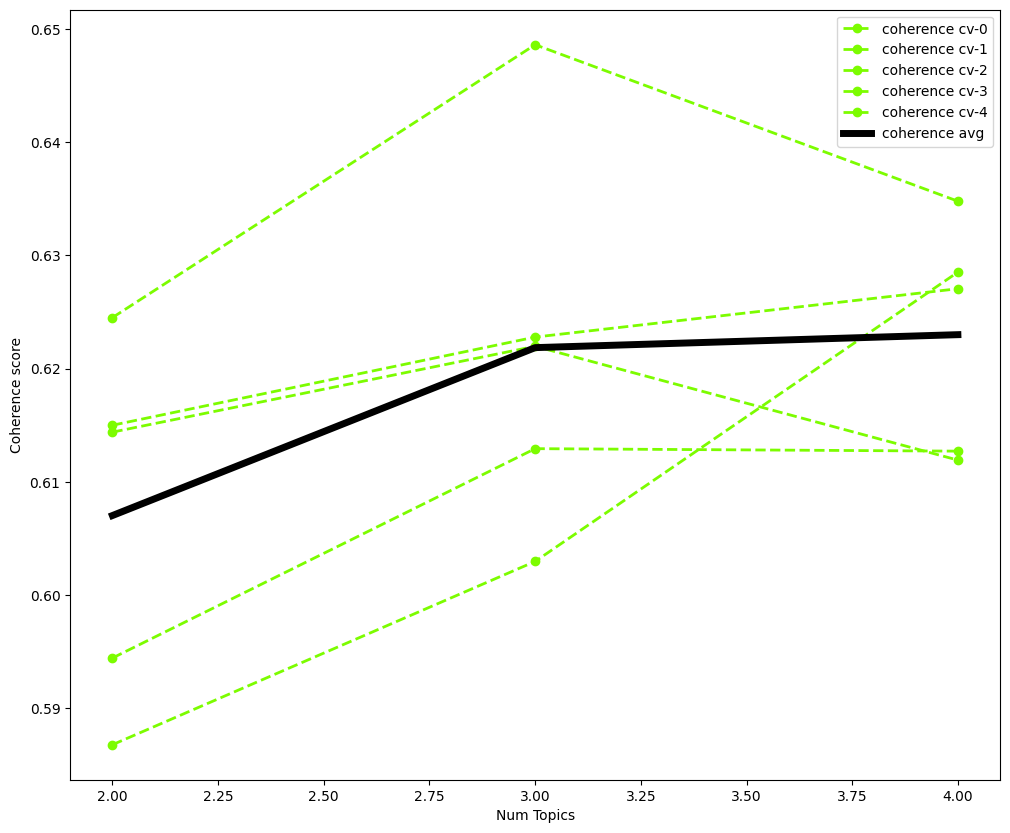

In [60]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(12,10))
for idx, c in enumerate(coh_t):
    plt.plot(x, c, '--', color = 'lawngreen', marker = 'o', linewidth = 2, label = f'coherence cv-{idx}')
plt.plot(x, coherence_t, '-', color = 'black', label = 'coherence avg', linewidth = 5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

## Analisis Graph dengan Gephi

In [63]:
users = data_clean['name']
tweets = data_clean['tweet']

graph = nx.Graph() # Graph Kosong Baru
graph.add_nodes_from(users)

print('Banyak vertex = ', graph.number_of_nodes())
print('Banyak Edges = ', graph.number_of_edges())

Banyak vertex =  4754
Banyak Edges =  0


In [64]:
for usr, t in zip(users, tweets):
    mentionS =  re.findall("@([a-zA-Z0-9]{1,15})", t)
    for mention in mentionS:
        if "." not in mention: #skipping emails
            graph.add_edge(usr, mention)
            
print('Banyak vertex = ', graph.number_of_nodes())
print('Banyak Edges = ', graph.number_of_edges())

Banyak vertex =  5339
Banyak Edges =  1061


In [65]:
print("Export ke GexF untuk di import ke Gephi")
nx.write_gexf(graph,"twitter data.gexf")

Export ke GexF untuk di import ke Gephi


## Visualisasi Graph dengan Gephi

## Analisis teks dengan Voyant.

In [66]:
data_clean['clean tweets'].to_csv('voyant files.txt', header = False, encoding = 'utf8', index = False)